Step 2

## Feature Engineering

In this notebook, we explore how each of the features have correlation with other and how it can affect the overall model performannce

In [18]:
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import seaborn as sns
import numpy as np
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [2]:
df = pd.read_csv("data/processed.csv",index_col=0)

## Preparing the Correlation Matrix

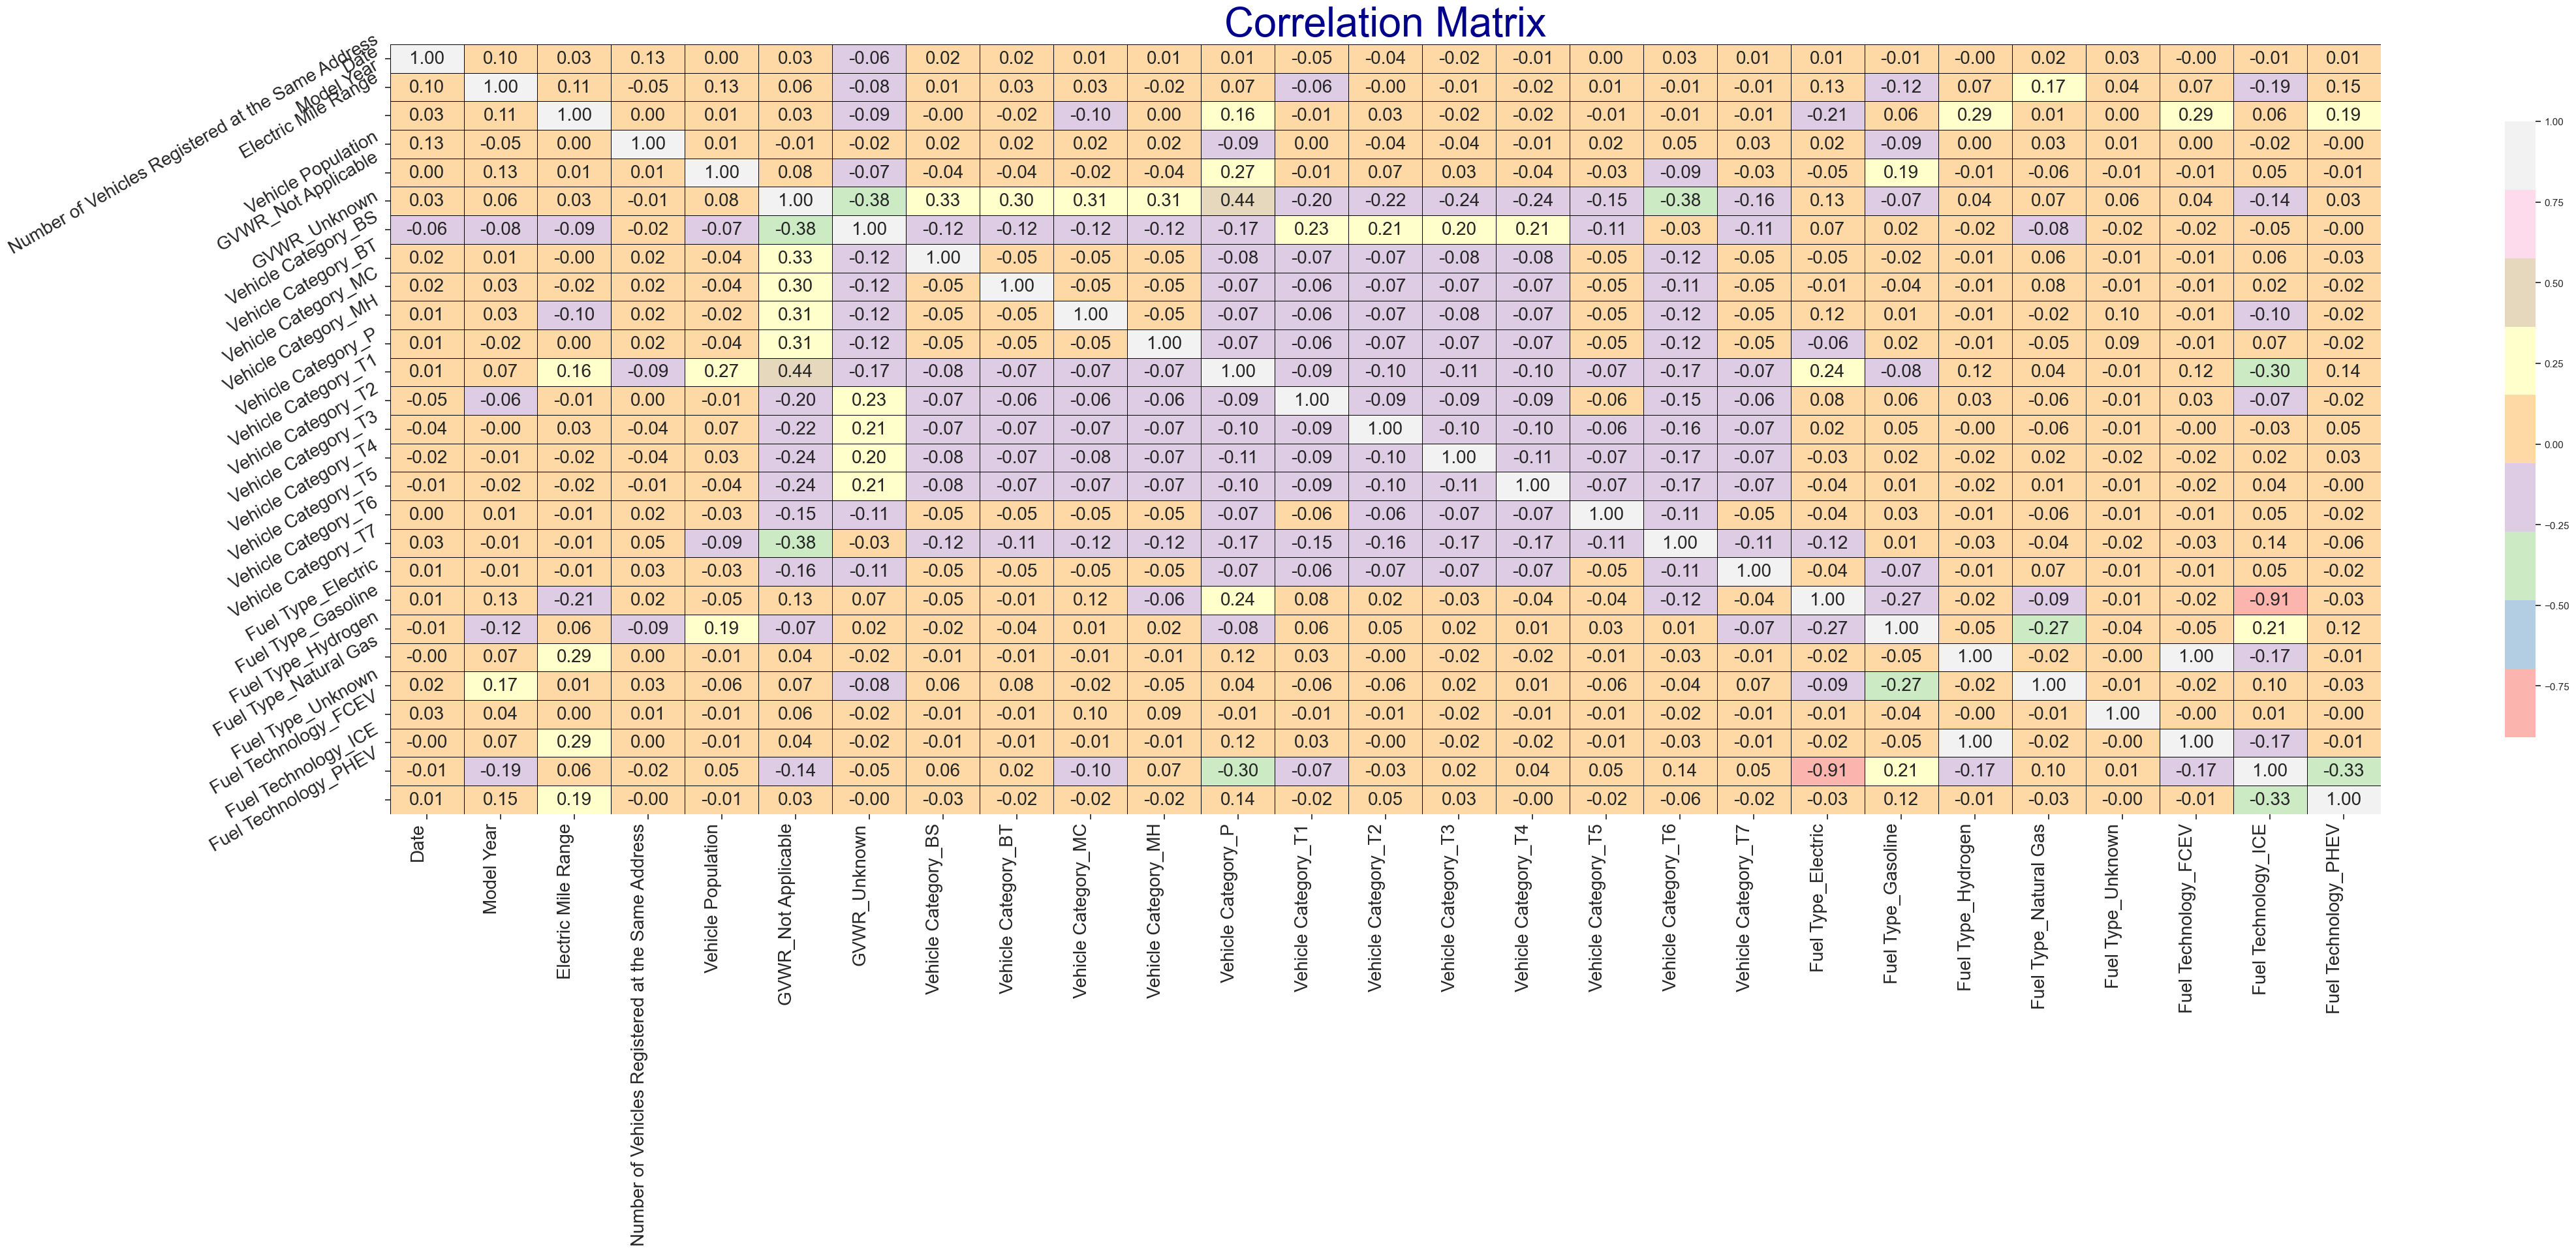

In [3]:
# Compute the correlation matrix
corr = df.corr()

# Set a clean, minimalistic style
sns.set(style="ticks")

# Create a figure with larger size for better readability
plt.figure(figsize=(45, 20))

# Plot the heatmap of the correlation matrix
sns.heatmap(corr, annot=True, fmt='.2f', cmap='Pastel1', linewidths=0.5, linecolor='black', 
            cbar_kws={'shrink': 0.8}, annot_kws={"size": 20})

# Add title and labels with adjusted font size
plt.title("Correlation Matrix", fontsize=45, color='darkblue', weight='normal')

# Rotate x and y axis labels for better readability
plt.xticks(rotation=90, ha='right', fontsize=20)
plt.yticks(rotation=30, ha='right', fontsize=20)

# Increase spacing between labels to prevent overlap
plt.tight_layout(pad=3)

# Save the plot as a PNG image
plt.savefig("correlation_matrix_brown.png", dpi=300)

# Show the plot
plt.show()

#### Above we can see the relationship between different features. For exmaple the ones highlighted in purple shows the positive correlations, however the one showing in red color has negative correlation

### Using VIF to identify multicolinearity

In [27]:
# Calculate VIF for each feature
vif_data = pd.DataFrame()
vif_data["Feature"] = df.columns
vif_data["VIF"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]

vif_data

/Users/vjaiwantx/projects/chevron-ev-production/env/lib/python3.13/site-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


,Feature,VIF
0,Date,1.036764e+00
1,Model Year,1.181807e+00
2,Electric Mile Range,1.255953e+00
3,Number of Vehicles Registered at the Same Address,1.058329e+00
4,Vehicle Population,1.234954e+00
5,GVWR_Not Applicable,7.384487e+05
6,GVWR_Unknown,1.432460e+00
7,Vehicle Category_BS,1.842556e+00
8,Vehicle Category_BT,1.749961e+00
9,Vehicle Category_MC,1.829353e+00


This suggests that:
1. The infinite VIF values for Hydrogen Fuel Type and FCEV Technology indicate perfect multicollinearity - these variables are exactly predictable from other variables in the dataset.
2. The extremely high VIF for GVWR and truck categories (T1-T7) suggests these categories are highly interdependent - possibly because certain vehicle categories are strongly associated with specific GVWR classes.
3. The moderate to high VIF values for electric-related variables (Fuel Type_Electric, Fuel Technology_ICE, PHEV) indicate some redundancy in how fuel types and technologies are encoded.

We shall proceed to remove the columns having higher VIF to make predictions easier

In [28]:
low_vif_features = vif_data[vif_data['VIF'] < 5]

In [29]:
low_vif_features

,Feature,VIF
0,Date,1.036764
1,Model Year,1.181807
2,Electric Mile Range,1.255953
3,Number of Vehicles Registered at the Same Address,1.058329
4,Vehicle Population,1.234954
6,GVWR_Unknown,1.432460
7,Vehicle Category_BS,1.842556
8,Vehicle Category_BT,1.749961
9,Vehicle Category_MC,1.829353
10,Vehicle Category_MH,1.782377


### Finding out features that affect the target's performance using RandomForestRegressor

In [4]:
model = RandomForestRegressor(n_estimators=100, random_state=42)

In [5]:
X = df.drop(['Vehicle Population'],axis=1)

In [6]:
y = df['Vehicle Population']

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [8]:
model.fit(X_train,y_train)

RandomForestRegressor(random_state=42)

In [9]:
# Evaluate
y_pred = model.predict(X_test)
print(f"RMSE: {root_mean_squared_error(y_test, y_pred)}")
print(f"R²: {r2_score(y_test, y_pred)}")

RMSE: 3630.3839312834357
R²: 0.9618894428320326


In [10]:
feature_importances = model.feature_importances_
feature_names = X_train.columns

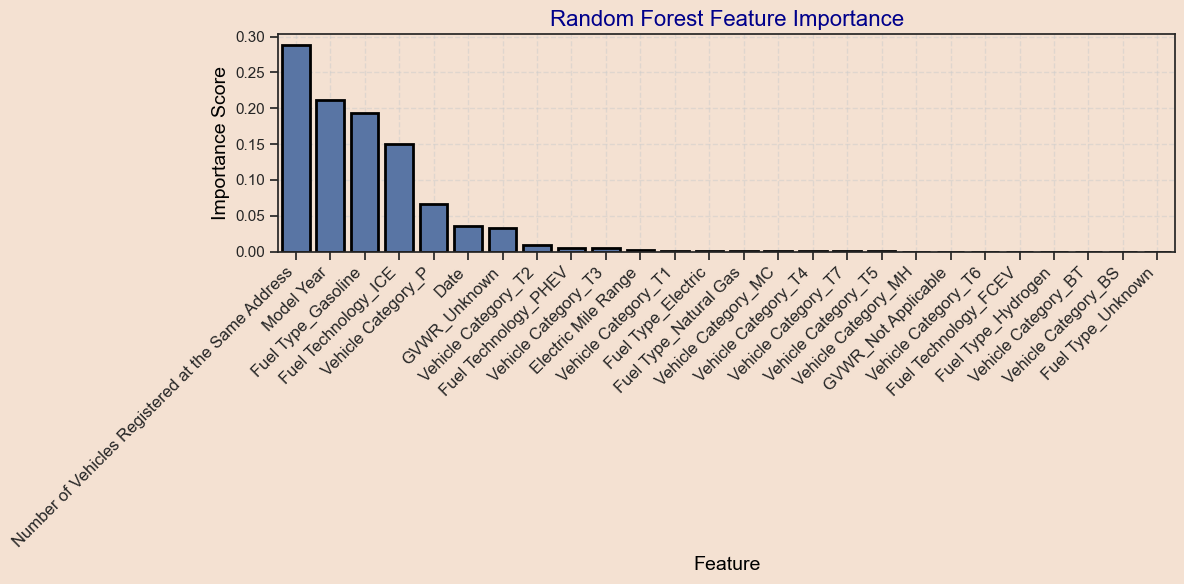

In [11]:
# Assuming 'feature_names' and 'feature_importances' are already defined
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Set a clean, minimalistic style
sns.set(style="ticks")

# Create a figure with larger size for better readability
plt.figure(figsize=(12, 6))

# Plot the feature importance bar chart
sns.barplot(x='Feature', y='Importance', data=importance_df, edgecolor="black", linewidth=2)

# Change the background color to light beige
plt.gcf().set_facecolor('#f4e1d2')  # Light brown color
plt.gca().set_facecolor('#f4e1d2')  # Light brown color for the plot area

# Refined plot title and labels
plt.title("Random Forest Feature Importance", fontsize=16, color='darkblue', weight='normal')
plt.xlabel("Feature", fontsize=14, color='black', weight='normal')
plt.ylabel("Importance Score", fontsize=14, color='black', weight='normal')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right', fontsize=12)

# Customize the grid for better readability
plt.grid(True, linestyle='--', alpha=0.5)

# Tight layout for a clean finish
plt.tight_layout()

# Show the plot
plt.show()

### Identifying Skewness in the target feature

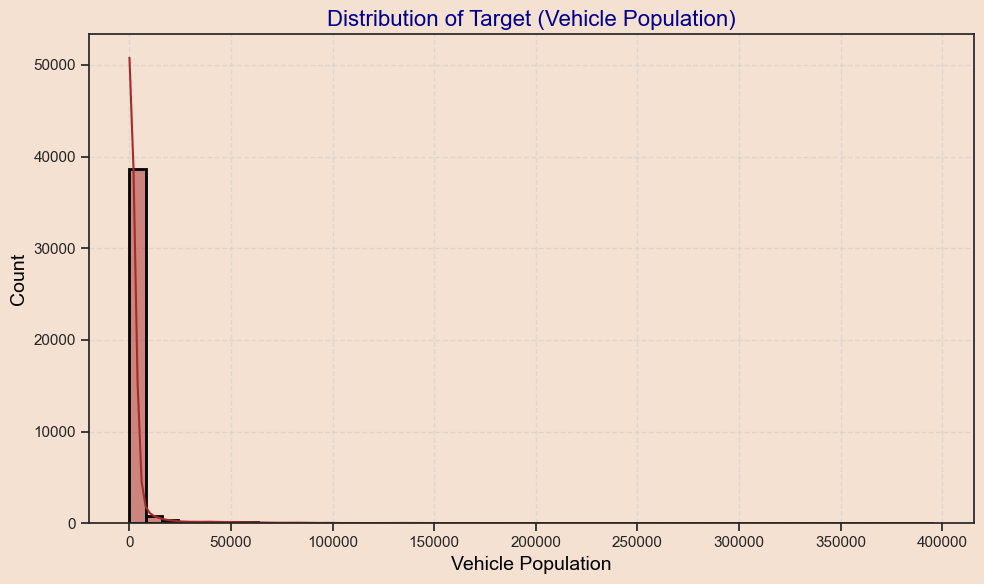

In [12]:
# Assuming 'y' is the target variable (Vehicle Population)
plt.figure(figsize=(10, 6))  # Larger figure for better readability

# Plot the histogram with KDE
sns.histplot(y, bins=50, kde=True, color='brown', edgecolor="black", linewidth=2)

# Set the background color to light beige
plt.gcf().set_facecolor('#f4e1d2')  # Light brown color
plt.gca().set_facecolor('#f4e1d2')  # Light brown color for the plot area

# Refined plot title and labels
plt.title("Distribution of Target (Vehicle Population)", fontsize=16, color='darkblue', weight='normal')
plt.xlabel("Vehicle Population", fontsize=14, color='black', weight='normal')
plt.ylabel("Count", fontsize=14, color='black', weight='normal')

# Customize the grid for better readability
plt.grid(True, linestyle='--', alpha=0.5)

# Tight layout for a clean finish
plt.tight_layout()

# Show the plot
plt.show()


The target variable is right skewed and training over skewed targets may not yield proper results. Hence scaling them can spread their distributions to refine better predictions

### Using log transform to normalize values 

In [13]:
y = np.log1p(y)

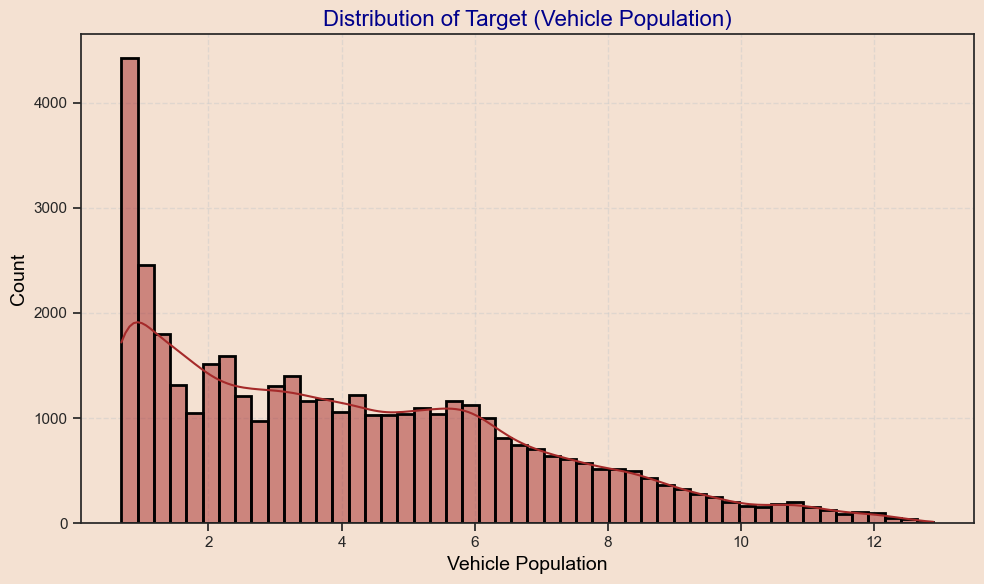

In [14]:
# Assuming 'y' is the target variable (Vehicle Population)
plt.figure(figsize=(10, 6))  # Larger figure for better readability

# Plot the histogram with KDE
sns.histplot(y, bins=50, kde=True, color='brown', edgecolor="black", linewidth=2)

# Set the background color to light beige
plt.gcf().set_facecolor('#f4e1d2')  # Light brown color
plt.gca().set_facecolor('#f4e1d2')  # Light brown color for the plot area

# Refined plot title and labels
plt.title("Distribution of Target (Vehicle Population)", fontsize=16, color='darkblue', weight='normal')
plt.xlabel("Vehicle Population", fontsize=14, color='black', weight='normal')
plt.ylabel("Count", fontsize=14, color='black', weight='normal')

# Customize the grid for better readability
plt.grid(True, linestyle='--', alpha=0.5)

# Tight layout for a clean finish
plt.tight_layout()

# Show the plot
plt.show()